# wstęp do uczenia maszynowego - projekt 1: "Credit Score", KM3
##  w tej części: bardziej zaawansowane modele, strojenie hiperparametrów, kroswalidacja, wybór ostatecznego modelu i metody wyjaśnialności

In [2]:
from library.tally import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier
from tpot import TPOTClassifier
import shap

from sklearn.metrics import classification_report

Dzielenie danych na zbiór walidacyjny i testowy, transformacja zmiennych, usuwanie wybranych kolumn i outlierów, mapowanie zmiennych kategorycznych (wdrożenie decyzji podjętych w KM2) za pomocą funkcji z library/tally.py

In [3]:
df_train = pd.read_csv('../data/for_modelling/credit_score_train.csv')
df_val = pd.read_csv('../data/for_modelling/credit_score_valid.csv')

df_train=map_gambling(df_train)
df_train = remove_columns_with_high_correlation(df_train)
#df_train = automatic_remove_outliers(df_train)
X_train, y_train = split_x_from_y(df_train)

#X_train, y_train=prepare_data(df_train)
df_val=map_gambling(df_val)
df_val = remove_columns_with_high_correlation(df_val)
X_val, y_val = split_x_from_y(df_val)
X_train, X_val = cox_box_transform(X_train, X_val)

# Komitety

Wybraliśmy kilka modeli używanych na zajęciach laboratoryjnych lub/i w KM2 (z KM2 tylko takie, które się najlepiej sprawdzały).

In [4]:
model0 = RandomForestClassifier(random_state=1)
model1 = DecisionTreeClassifier(random_state=1)
model2 = KNeighborsClassifier()
model3 = LogisticRegression(random_state=1, max_iter=1000) #jeden z lepszych w KM2
model4 = MLPClassifier(random_state=42, max_iter=1000) #jeden z lepszych w KM2
model5 = GradientBoostingClassifier(random_state=1)
model6 = GaussianNB() #najlepiej się sprawdzał w KM2
model7 = QuadraticDiscriminantAnalysis() #jeden z lepszych w KM2
model8 = SGDClassifier(random_state=42) #jeden z lepszych w KM2




estimators=[('RandomForest', model0),('DecisionTree', model1), ('KNN', model2), ('LR', model3),  ('MLP', model4),
            ('GradientBoosting', model5),
            ('NaiveBayes', model6), ('QDA', model7), ('SGD', model8)]

from sklearn.ensemble import VotingClassifier
model_hard = VotingClassifier(estimators=estimators[0:8], voting='hard')

Hard Voting

In [61]:
from sklearn.metrics import classification_report

model_hard.fit(X_train,y_train)

y_hat = model_hard.predict(X_val)
print('f1 score: ', f1_score(y_val, y_hat))

print('model.score: ', model_hard.score(X_val,y_val))
report = classification_report(y_val, y_hat)
print(report)

f1 score:  0.2711864406779661
model.score:  0.6884057971014492
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        99
           1       0.40      0.21      0.27        39

    accuracy                           0.69       138
   macro avg       0.57      0.54      0.54       138
weighted avg       0.64      0.69      0.65       138


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Soft Voting

In [62]:
model_soft = VotingClassifier(estimators=estimators[0:8], voting='soft')
model_soft.fit(X_train, y_train)

y_hat = model_soft.predict(X_val)
f1_score(y_val, y_hat)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.75      0.75        99
           1       0.38      0.38      0.38        39

    accuracy                           0.64       138
   macro avg       0.57      0.57      0.57       138
weighted avg       0.65      0.64      0.65       138


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Soft Voting z wagami (najwieksze wagi dla estymatorow, które wyszlo nam ze sa dobre w KM2)

In [63]:
model_soft = VotingClassifier(estimators=estimators[0:8], voting='soft', weights=[1,1,1,2,2,1,3,2])
model_soft.fit(X_train, y_train)

y_hat = model_soft.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.62      0.68        99
           1       0.34      0.51      0.41        39

    accuracy                           0.59       138
   macro avg       0.55      0.56      0.55       138
weighted avg       0.64      0.59      0.61       138


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Spróbujmy pozmieniać trochę wagi

In [64]:
model_soft = VotingClassifier(estimators=estimators[0:8], voting='soft', weights=[1,1,1,3,3,1,3,3])
model_soft.fit(X_train, y_train)

y_hat = model_soft.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.64      0.69        99
           1       0.35      0.49      0.40        39

    accuracy                           0.59       138
   macro avg       0.55      0.56      0.55       138
weighted avg       0.64      0.59      0.61       138


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [65]:
model_soft = VotingClassifier(estimators=estimators[0:8], voting='soft', weights=[1,1,1,3,3,1,20,15])
model_soft.fit(X_train, y_train)

y_hat = model_soft.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.40      0.54        99
           1       0.33      0.74      0.46        39

    accuracy                           0.50       138
   macro avg       0.56      0.57      0.50       138
weighted avg       0.67      0.50      0.51       138


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [67]:
model_soft = VotingClassifier(estimators=estimators[0:8], voting='soft', weights=[1,1,1,5,1,1,25,15])
model_soft.fit(X_train, y_train)

y_hat = model_soft.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.30      0.44        99
           1       0.32      0.85      0.47        39

    accuracy                           0.46       138
   macro avg       0.58      0.57      0.46       138
weighted avg       0.69      0.46      0.45       138


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ostatnie wagi najlepsze

# Stacking

In [68]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train).score(X_val, y_val)
y_hat = clf.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

           0       0.73      0.97      0.83        99
           1       0.57      0.10      0.17        39

    accuracy                           0.72       138
   macro avg       0.65      0.54      0.50       138
weighted avg       0.69      0.72      0.65       138


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [69]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators, final_estimator=GaussianNB())
clf.fit(X_train, y_train).score(X_val, y_val)
y_hat = clf.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

           0       0.76      0.79      0.78        99
           1       0.42      0.38      0.40        39

    accuracy                           0.67       138
   macro avg       0.59      0.59      0.59       138
weighted avg       0.67      0.67      0.67       138


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Bagging

In [73]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(estimator=model6
                        ,n_estimators=10, random_state=0)
clf.fit(X_train, y_train)
y_hat = clf.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.28      0.42        99
           1       0.31      0.82      0.45        39

    accuracy                           0.43       138
   macro avg       0.56      0.55      0.43       138
weighted avg       0.66      0.43      0.43       138


BaggingClassifier z modelem6 (GausianNB) najlepszy

## Random Forest Classifier

In [74]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=1000, 
                                  max_depth=3,
                                  min_samples_split = 2, 
                                  max_features = 3, 
                                  random_state=0,
                                  n_jobs = -1)
model_rf.fit(X_train, y_train)
y_hat = model_rf.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.99      0.83        99
           1       0.50      0.03      0.05        39

    accuracy                           0.72       138
   macro avg       0.61      0.51      0.44       138
weighted avg       0.66      0.72      0.61       138


## AdaBoostClassifier

In [75]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=1)
model.fit(X_train, y_train)
y_hat = model.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.75      0.84      0.79        99
           1       0.43      0.31      0.36        39

    accuracy                           0.69       138
   macro avg       0.59      0.57      0.58       138
weighted avg       0.66      0.69      0.67       138


## Gradient Boosting

In [76]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=1,
                                   learning_rate=0.01)
model.fit(X_train, y_train)
y_hat = model.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.96      0.83        99
           1       0.56      0.13      0.21        39

    accuracy                           0.72       138
   macro avg       0.65      0.54      0.52       138
weighted avg       0.69      0.72      0.66       138


## XGBoost z booster=gbtree

In [78]:
from xgboost import XGBClassifier
model=XGBClassifier(random_state=1,
                    learning_rate=0.01, 
                    booster='gbtree',  #(drzewo - gbtree, liniowe - gblinear)
                    max_depth=4 
                    )
model.fit(X_train, y_train)
y_hat = model.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.95      0.84        99
           1       0.58      0.18      0.27        39

    accuracy                           0.73       138
   macro avg       0.66      0.56      0.56       138
weighted avg       0.70      0.73      0.68       138


## XGBoost z booster=gblinear

In [79]:
model=XGBClassifier(random_state=1,
                    learning_rate=0.01, 
                    booster='gblinear', #(drzewo - gbtree, liniowe - gblinear)
                     )
model.fit(X_train, y_train)
y_hat = model.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.92      0.83        99
           1       0.53      0.23      0.32        39

    accuracy                           0.72       138
   macro avg       0.64      0.57      0.57       138
weighted avg       0.69      0.72      0.68       138


In [80]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
level0 = [
    ('lr', LogisticRegression()),
    ('svc', SVC()),
    ('dt', DecisionTreeClassifier())
]
# Meta-model, który podsumowuje przewidywania bazowych modeli
level1 = LogisticRegression()


model_stacking = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

model_stacking.fit(X_train, y_train)
y_hat = model.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.92      0.83        99
           1       0.53      0.23      0.32        39

    accuracy                           0.72       138
   macro avg       0.64      0.57      0.57       138
weighted avg       0.69      0.72      0.68       138


# Strojenie Parametrów
### Decision Tree

wybieramy jak najwięcej różnych parametrów dla decisionTree i przechodzimy po nich, sprawdzając, który daje najlepszy wynik

In [83]:
tree_model= DecisionTreeClassifier()
from sklearn.model_selection import GridSearchCV
max_depth=[3, 5, 6, 7, 8]
ccp_alpha=[0,0.01, 0.02, 0.05, 0.1, 0.2]
splitter=["best", "random"]
min_samples_split=[2, 5, 10]
min_samples_leaf=[1, 2, 4]
max_features=["auto", "sqrt", "log2"]

param_grid = {
    'splitter': splitter,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'ccp_alpha': ccp_alpha
}

grid = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv = 3, n_jobs=-1, scoring='f1')

grid_result = grid.fit(X_train, y_train) 

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.386175 using {'ccp_alpha': 0, 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'random'}


sprawdzmy jeszcze patrzac na recall, zamiast f1

In [87]:
grid = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv = 3, n_jobs=-1, scoring='recall')

grid_result = grid.fit(X_train, y_train) 

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.396238 using {'ccp_alpha': 0, 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}


taki sam najlepszy

najlepsze parametry dla decisionTree

In [88]:
best_model=grid_result.best_estimator_
best_model

DecisionTreeClassifier(ccp_alpha=0, max_depth=8, min_samples_leaf=2,
                       min_samples_split=5, splitter='random')

wyniki dla tych parametrow

In [89]:
best_model.fit(X_train, y_train)
y_hat = best_model.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.93      0.81        99
           1       0.36      0.10      0.16        39

    accuracy                           0.70       138
   macro avg       0.54      0.52      0.49       138
weighted avg       0.62      0.70      0.63       138


wynik: decision tree słabe

### Gradient Boosting

teraz robimy grid search dla gradient boostingu, tak samo podajac jak najwiecej parametrow i szukajac najlepszych wartosci dla kazdego z nich

In [90]:
max_depth = [3, 5, 6, 7, 8]
loss = ["deviance", "exponential"]
learning_rate = [0.001, 0.01, 0.1]
n_estimators = [10, 50, 100, 200]
subsample = [0.5, 0.75, 1.0]
max_features = ["auto", "sqrt", "log2"]

param_grid = {
    'loss': loss,
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'subsample': subsample,
    'max_depth': max_depth,
    'max_features': max_features,
    'ccp_alpha': ccp_alpha
}
gb_model = GradientBoostingClassifier()

grid = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv = 3, n_jobs=-1, scoring='f1')

grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
12960 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5427 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Dell\anaconda3\Lib\site-packag

Best: 0.373039 using {'ccp_alpha': 0.01, 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 0.5}


In [68]:
grid_result.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.01, loss='exponential', max_depth=8,
                           max_features='log2', n_estimators=200,
                           subsample=0.5)

In [69]:
y_hat=grid_result.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.91      0.85        99
           1       0.62      0.38      0.48        39

    accuracy                           0.76       138
   macro avg       0.71      0.65      0.66       138
weighted avg       0.74      0.76      0.74       138


### Random Forest

In [91]:
max_depth = [3, 5, 6, 7, 8]
criterion = ["gini", "entropy"]
ccp_alpha = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
max_features = ["auto", "sqrt", "log2"]
n_estimators = [10, 50, 100, 200]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'criterion': criterion,
    'ccp_alpha': ccp_alpha
}

rf_model = RandomForestClassifier()

grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

grid_result = grid.fit(X_train, y_train)

print("Best F1-score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best F1-score: 0.354770 using {'bootstrap': False, 'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}


In [92]:
y_hat=grid_result.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.94      0.83        99
           1       0.50      0.15      0.24        39

    accuracy                           0.72       138
   macro avg       0.62      0.55      0.53       138
weighted avg       0.67      0.72      0.66       138


## gausianNB

In [98]:
from sklearn.model_selection import StratifiedKFold


# Ustal parametry i model
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

nb_model = GaussianNB()

grid = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=StratifiedKFold(3), n_jobs=-1, scoring='f1')
grid_result = grid.fit(X_train, y_train)

y_hat = grid_result.best_estimator_.predict(X_val)

print("Best F1-score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
report = classification_report(y_val, y_hat)
print(report)

Best F1-score: 0.485993 using {'var_smoothing': 1e-05}
              precision    recall  f1-score   support

           0       0.80      0.37      0.51        99
           1       0.33      0.77      0.46        39

    accuracy                           0.49       138
   macro avg       0.57      0.57      0.48       138
weighted avg       0.67      0.49      0.50       138


## QDA

In [9]:
QDAmodel=QuadraticDiscriminantAnalysis()
QDAmodel.get_params()
from sklearn.model_selection import GridSearchCV

In [14]:
param_grid = {
    'reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'tol': [1e-3, 1e-4, 1e-5],
    'priors': [None, [0.5, 0.5], [0.7, 0.3], [0.3, 0.7]],  # przykładowe wartości
    'store_covariance': [True, False]
}
grid= GridSearchCV(QDAmodel, param_grid, cv=5,  verbose=1, n_jobs=-1, scoring='f1')

grid_result = grid.fit(X_train, y_train)

y_hat = grid_result.best_estimator_.predict(X_val)

print("Best F1-score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
report = classification_report(y_val, y_hat)
print(report)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best F1-score: 0.466625 using {'priors': [0.3, 0.7], 'reg_param': 0.3, 'store_covariance': True, 'tol': 0.001}
              precision    recall  f1-score   support

           0       0.82      0.40      0.54        99
           1       0.34      0.77      0.47        39

    accuracy                           0.51       138
   macro avg       0.58      0.59      0.50       138
weighted avg       0.68      0.51      0.52       138


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


# Random search

dla GausianNB

In [19]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'var_smoothing': [1e-12, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
}

nb_model = GaussianNB()
random = RandomizedSearchCV(estimator=nb_model, param_distributions=param_grid, cv = 3, n_jobs=-1, scoring='f1')

random_result = random.fit(X_train, y_train)
model=random_result.best_estimator_
y_hat=model.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)
print("Best F1-score: %f using %s" % (random_result.best_score_, random_result.best_params_))

              precision    recall  f1-score   support

           0       0.78      0.38      0.51        99
           1       0.31      0.72      0.44        39

    accuracy                           0.48       138
   macro avg       0.55      0.55      0.48       138
weighted avg       0.65      0.48      0.49       138

Best F1-score: 0.494626 using {'var_smoothing': 0.01}


# Bayes search

dla gausianNB (dla innych nie ma sensu, słabo działają, sprawdzone w advanced_models_ania)

In [20]:
from skopt import BayesSearchCV

opt = BayesSearchCV(
    GaussianNB(),
    {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    n_iter=5,
    cv=3, scoring='f1'
)

result = opt.fit(X_train, y_train)
model=result.best_estimator_
y_hat=model.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)
print("Best F1-score: %f using %s" % (random_result.best_score_, random_result.best_params_))

              precision    recall  f1-score   support

           0       0.80      0.36      0.50        99
           1       0.32      0.77      0.45        39

    accuracy                           0.48       138
   macro avg       0.56      0.57      0.48       138
weighted avg       0.67      0.48      0.49       138

Best F1-score: 0.494626 using {'var_smoothing': 0.01}


autoML zostało sprawdzone w pliku advanced_models_ania - dziala slabo

# TPOT

In [17]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
result = tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7408163265306122

Generation 2 - Current best internal CV score: 0.7428571428571429

Generation 3 - Current best internal CV score: 0.7428571428571429

Generation 4 - Current best internal CV score: 0.746938775510204

Generation 5 - Current best internal CV score: 0.7469387755102042

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.5, min_samples_leaf=5, min_samples_split=15, n_estimators=100)


In [18]:
print("Accuracy on testing data: ", tpot.score(X_val, y_val))

Accuracy on testing data:  0.7246376811594203


AttributeError: 'TPOTClassifier' object has no attribute 'f1_score'

## Podsumowanie - jedyne sensowne wyniki dla:
- VotingClassifier(estimators=estimators[0:8], voting='soft', weights=[1,1,1,5,1,1,25,15])
- BaggingClassifier(estimator=model6 ,n_estimators=10, random_state=0) (troche gorsze niz 1)
- gausianNB using {'var_smoothing': 1e-05}
- gausianNB using {'var_smoothing': 1e-12}
- QDA {'priors': [0.3, 0.7], 'reg_param': 0.3, 'store_covariance': True, 'tol': 0.001} (troche gorsze niz 1)

# Cross Validation - Second Part

In [42]:
#load data
df_train = pd.read_csv('../data/for_modelling/credit_score_train.csv')
df_val = pd.read_csv('../data/for_modelling/credit_score_valid.csv')
from sklearn.ensemble import BaggingClassifier
df_train=map_gambling(df_train)
# I have problem with automatic_remove_outliers

X_train, y_train = split_x_from_y(df_train)
X_train=remove_columns_with_high_correlation(X_train)


df_val=map_gambling(df_val)

X_val, y_val = split_x_from_y(df_val)
X_val=remove_columns_with_high_correlation(X_val)

#defining models
model0 = RandomForestClassifier(random_state=1)
model1 = DecisionTreeClassifier(random_state=1)
model2 = KNeighborsClassifier()
model3 = LogisticRegression(random_state=1, max_iter=1000) #jeden z lepszych w KM2
model4 = MLPClassifier(random_state=42, max_iter=1000) #jeden z lepszych w KM2
model5 = GradientBoostingClassifier(random_state=1)
model6 = GaussianNB() #najlepiej się sprawdzał w KM2
model7 = QuadraticDiscriminantAnalysis() #jeden z lepszych w KM2
model8 = SGDClassifier(random_state=42) #jeden z lepszych w KM2


QDAmodel=QuadraticDiscriminantAnalysis(priors =[0.3, 0.7], reg_param = 0.3, store_covariance =True, tol = 0.001)
estimators=[('RandomForest', model0),('DecisionTree', model1), ('KNN', model2), ('LR', model3),  ('MLP', model4),
            ('GradientBoosting', model5),
            ('NaiveBayes', model6), ('QDA', model7), ('SGD', model8)]
model9 = BaggingClassifier(estimator=GaussianNB() ,n_estimators=10, random_state=0)

#defining voting classifier
model_voting = VotingClassifier(estimators=estimators[0:8], voting='soft', weights=[1,1,1,5,1,1,25,15])

names=['LogisticRegression', 'XGBClassifier', 'GradientBoostingClassifier', 'GaussianNB(1e-12)', 'GaussianNB(1e-05)', 'SoftVotingClassifier', 'BaggingClassifier', 'QDA']


models=[XGBClassifier(random_state=42, learning_rate=0.01, booster='gbtree', max_depth=4), GradientBoostingClassifier(random_state=42, learning_rate=0.1, loss='exponential', max_depth=3, max_features='sqrt', n_estimators=100, subsample=0.5), GaussianNB(var_smoothing=1e-12), GaussianNB(var_smoothing=1e-05), LogisticRegression(random_state=42), model_voting, model9, QDAmodel]

s=create_tally(X_train, X_val, y_train, y_val, models=models, names=names)
s

C:\Users\Dell\anaconda3\Lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Dell\anaconda3\Lib\site-packages\numpy\core\_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
C:\Users\Dell\anaconda3\Lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Dell\anaconda3\Lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Dell\anaconda3\Lib\site-packages\numpy\core\_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
C:\Users\Dell\anaconda3\Lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Dell\anaconda3\Lib\

,model,accuracy,accuracy_std,precision,precision_std,recall,recall_std,f1,f1_std
0,LogisticRegression,0.727683,0.036433,0.629841,0.296587,0.123492,0.058368,0.205325,0.096108
0,XGBClassifier,0.694311,0.042004,0.403015,0.173062,0.179683,0.086070,0.247700,0.113528
0,GradientBoostingClassifier,0.407644,0.035635,0.313954,0.010005,0.916190,0.063067,0.467024,0.012299
0,GaussianNB(1e-12),0.500000,0.048000,0.339397,0.024949,0.798095,0.068055,0.475298,0.030544
0,GaussianNB(1e-05),0.697410,0.036087,0.438797,0.120167,0.285873,0.090187,0.345532,0.102926
0,SoftVotingClassifier,0.447479,0.036680,0.323191,0.016509,0.865714,0.074734,0.470042,0.024493
0,BaggingClassifier,0.444305,0.037775,0.321038,0.019391,0.860000,0.069656,0.467160,0.028247
0,QDA,0.522273,0.027367,0.342200,0.014017,0.741746,0.072915,0.467296,0.022470


We see that according to std of precision and f1 these models are highly unstable:
- LogisticRegression
- XGBClassifier
- GaussianNB(1e-05)

We see that Combination of models deals with the problem.

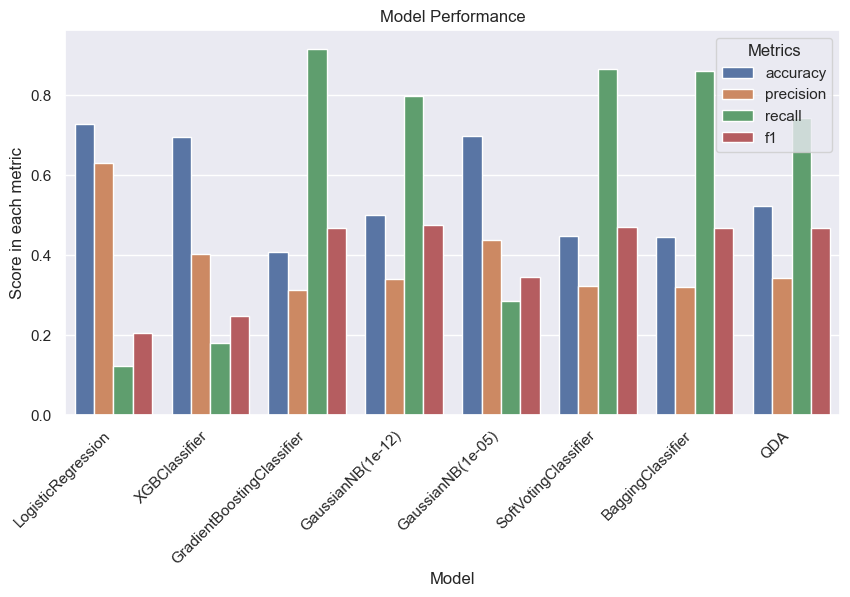

In [43]:
create_visualization(s)

If we look at mean of metrics we can say that these models are the best:
- GradientBoostingClassifier
- a little bit GaussianNB
- SoftVotingClassifier
- Bagging Classifier
- QDA

# Test our models using test set

In [44]:
df_test=pd.read_csv('../data/for_modelling/credit_score_test.csv')

df_test=map_gambling(df_test)
X_test, y_test = split_x_from_y(df_test)
X_test=remove_columns_with_high_correlation(X_test)

score=validate(X_train, X_test, y_train, y_test, models, names)
score

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,model,accuracy,precision,recall,f1
0,LogisticRegression,0.750000,0.800000,0.190476,0.307692
0,XGBClassifier,0.777778,1.000000,0.238095,0.384615
0,GradientBoostingClassifier,0.416667,0.322034,0.904762,0.475000
0,GaussianNB(1e-12),0.458333,0.326923,0.809524,0.465753
0,GaussianNB(1e-05),0.680556,0.416667,0.238095,0.303030
0,SoftVotingClassifier,0.444444,0.327273,0.857143,0.473684
0,BaggingClassifier,0.444444,0.327273,0.857143,0.473684
0,QDA,0.555556,0.372093,0.761905,0.500000


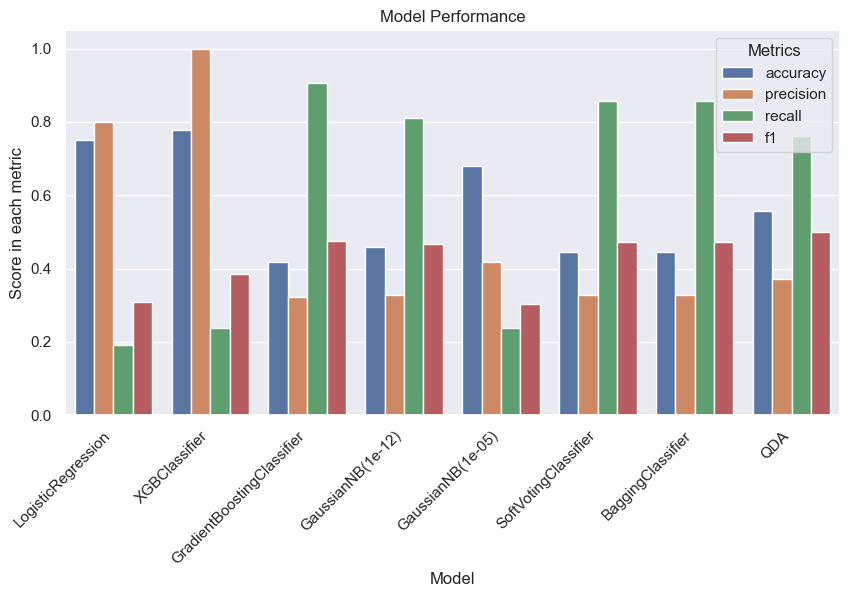

In [45]:
create_visualization(score)

Najlepsze modele:
- GradientBoosting
- GausianNb(1e-12)
- SoftVoting z wagami 
- BaggingClassifier
- QDA

## Explanable AI - 3rd Part

In [10]:
df_train = pd.read_csv('../data/for_modelling/credit_score_train.csv')
df_val = pd.read_csv('../data/for_modelling/credit_score_valid.csv')


df_train=map_gambling(df_train)
df_train = remove_columns_with_high_correlation(df_train)
X_train, y_train = split_x_from_y(df_train)

#X_train, y_train=prepare_data(df_train)
df_val=map_gambling(df_val)
df_val = remove_columns_with_high_correlation(df_val)
X_val, y_val = split_x_from_y(df_val)

model_xgboost=XGBClassifier(random_state=1,learning_rate=0.01,booster='gbtree',max_depth=4)
model_xgboost.fit(X_train, y_train)
y_hat=model_xgboost.predict(X_val)
report = classification_report(y_val, y_hat)
print(report)


              precision    recall  f1-score   support

           0       0.75      0.95      0.84        99
           1       0.58      0.18      0.27        39

    accuracy                           0.73       138
   macro avg       0.66      0.56      0.56       138
weighted avg       0.70      0.73      0.68       138


In [11]:
X_val

,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_6,R_CLOTHING,R_CLOTHING_INCOME,R_CLOTHING_SAVINGS,...,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE
0,15221,3044,0,0.2000,0.0000,0.0000,75,0.3846,0.0128,0.0641,...,1.0000,5.0003,0.0000,0,0,0,0,1,0,645
1,169063,783839,1859697,4.6364,11.0000,2.3725,14437,0.8472,0.1008,0.0217,...,0.9091,0.1961,0.0826,2,1,1,0,1,1,547
2,70477,56382,288956,0.8000,4.1000,5.1250,11140,0.7181,0.2201,0.2751,...,1.0000,1.2500,0.2439,0,1,0,0,1,0,606
3,72542,87050,696403,1.2000,9.6000,8.0000,4094,0.6141,0.0919,0.0766,...,1.0000,0.8333,0.1042,0,1,0,1,1,0,585
4,84772,254315,952051,3.0000,11.2307,3.7436,379,0.0427,0.1047,0.0349,...,0.7692,0.2564,0.0685,0,1,0,0,1,0,548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,386976,1250231,654883,3.2308,1.6923,0.5238,30569,0.8337,0.0947,0.0293,...,0.7692,0.2381,0.4545,0,1,0,0,1,0,562
134,16772,8386,0,0.5000,0.0000,0.0000,186,0.7815,0.0142,0.0284,...,1.2500,2.5000,0.9786,0,0,0,0,1,0,619
135,137509,206264,206264,1.5000,1.5000,1.0000,10865,0.6938,0.1139,0.0759,...,1.0000,0.6667,0.6667,0,1,0,0,1,0,639
136,259146,1922000,1662854,7.4167,6.4167,0.8652,8527,0.7001,0.0470,0.0063,...,0.8333,0.1124,0.1299,2,1,1,0,1,1,587


In [12]:
X_train

,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_6,R_CLOTHING,R_CLOTHING_INCOME,R_CLOTHING_SAVINGS,...,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE
0,2783,1855,0,0.6665,0.0000,0.0000,74,0.7184,0.0370,0.0555,...,1.6665,2.5003,0.0000,0,0,0,0,1,0,570
1,314430,445442,707468,1.4167,2.2500,1.5882,29157,0.8131,0.1141,0.0805,...,0.8333,0.5882,0.3704,2,1,0,1,1,0,691
2,161773,517674,2782496,3.2000,17.2000,5.3750,2533,0.6816,0.0230,0.0072,...,1.0000,0.3125,0.0581,0,1,1,1,1,1,520
3,16014,97685,20818,6.1000,1.3000,0.2131,187,0.2936,0.0398,0.0065,...,1.0000,0.1639,0.7692,0,1,0,0,1,0,654
4,193225,1410542,2589215,7.3000,13.4000,1.8356,2325,0.4407,0.0273,0.0037,...,1.0000,0.1370,0.0746,0,1,1,0,1,1,552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,20007,22508,457665,1.1250,22.8752,20.3334,861,0.5934,0.0725,0.0645,...,1.2500,1.1111,0.0546,0,1,0,0,1,0,423
486,20846,268679,23162,12.8888,1.1111,0.0862,533,0.4094,0.0625,0.0048,...,1.1111,0.0862,1.0000,1,1,0,0,1,0,584
487,89235,1106514,160623,12.4000,1.8000,0.1452,835,0.3460,0.0270,0.0022,...,1.0000,0.0806,0.5556,0,1,0,0,1,0,631
488,197073,1021195,1863233,5.1818,9.4545,1.8246,3948,0.4691,0.0427,0.0082,...,0.9091,0.1754,0.0962,2,1,0,1,1,1,572


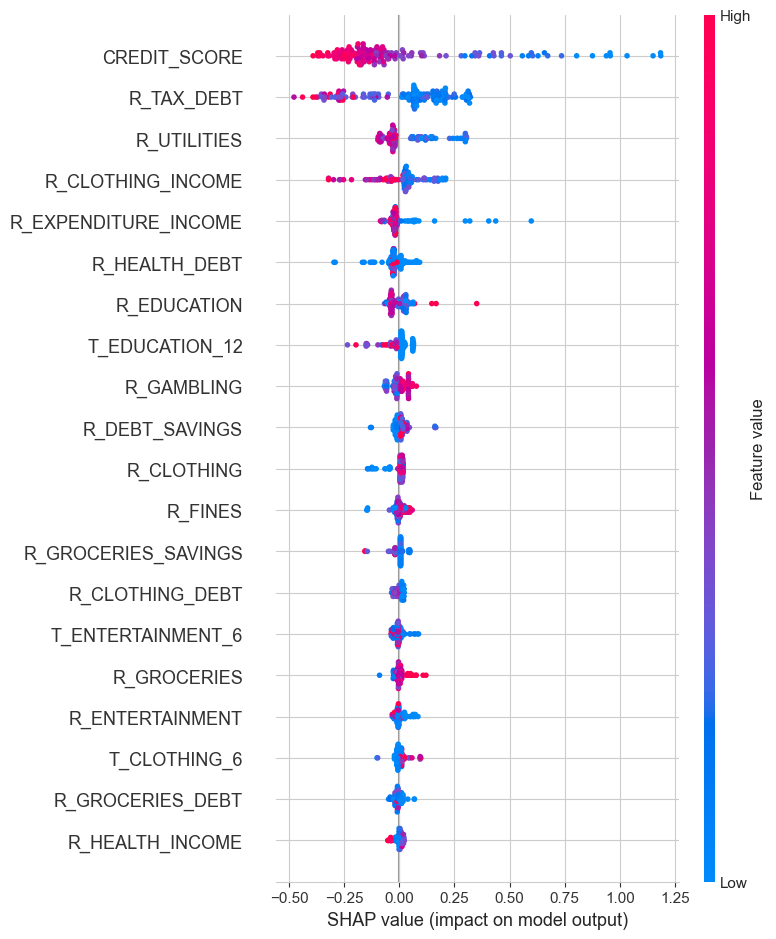

In [14]:
explainer_shap_xgboost = shap.TreeExplainer(model_xgboost)
shap_values_xgboost = explainer_shap_xgboost.shap_values(X_val)
col=X_val.columns
shap.summary_plot(shap_values_xgboost, X_val, col)

Conslusions and explanations:
- features are listed from top to bottom based on their impact on the model output. The most important features have the greatest influence on model predictions. We can see CREDIT_SCORE is the most important and it would seem resonable.
- the color represents the feature value (red high, blue low). For example, we can see that the higher the CREDIT_SCORE, the lower the probability of default.
- the horizontal spread of the dots shows the distribution of the feature impact on the model. A wider spread means the impact of that feature on the predictions varies more among different observations.

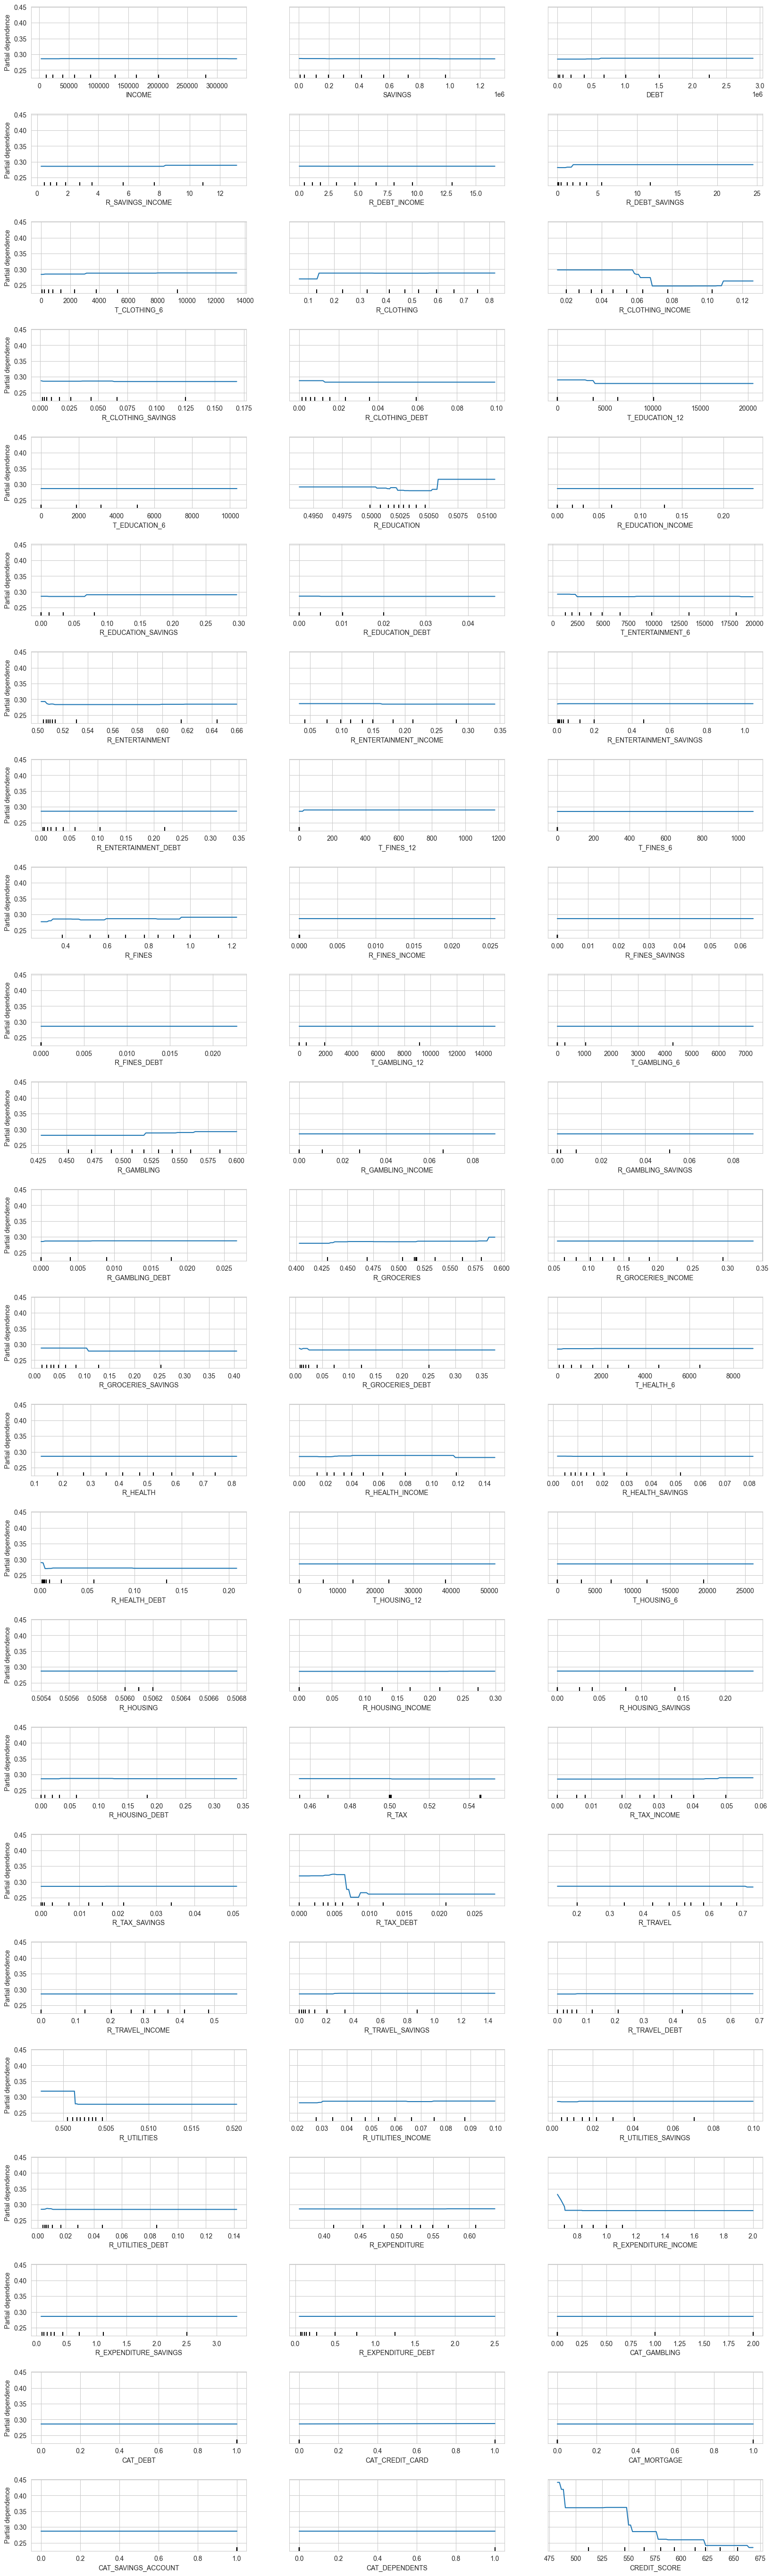

In [16]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(20, 70))
PartialDependenceDisplay.from_estimator(model_xgboost, X_train, features=list(range(72)), feature_names=col, ax=ax)
plt.subplots_adjust(hspace=0.5)

Conslusions:
- the most important feature is CREDIT_SCORE, which is consistent with SHAP (SHAP and PDP showed that the higher the CREDIT_SCORE, the lower the probability of default).
- there are many features that have a marginal impact on the model output and only few with bigger impact (like R_EDUCATION nad R_CLOTHING_INCOME, but these still isn't big impact on the model olutput).

In [17]:
model_naive_bayes = GaussianNB(var_smoothing=1e-05)
model_naive_bayes.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-05)

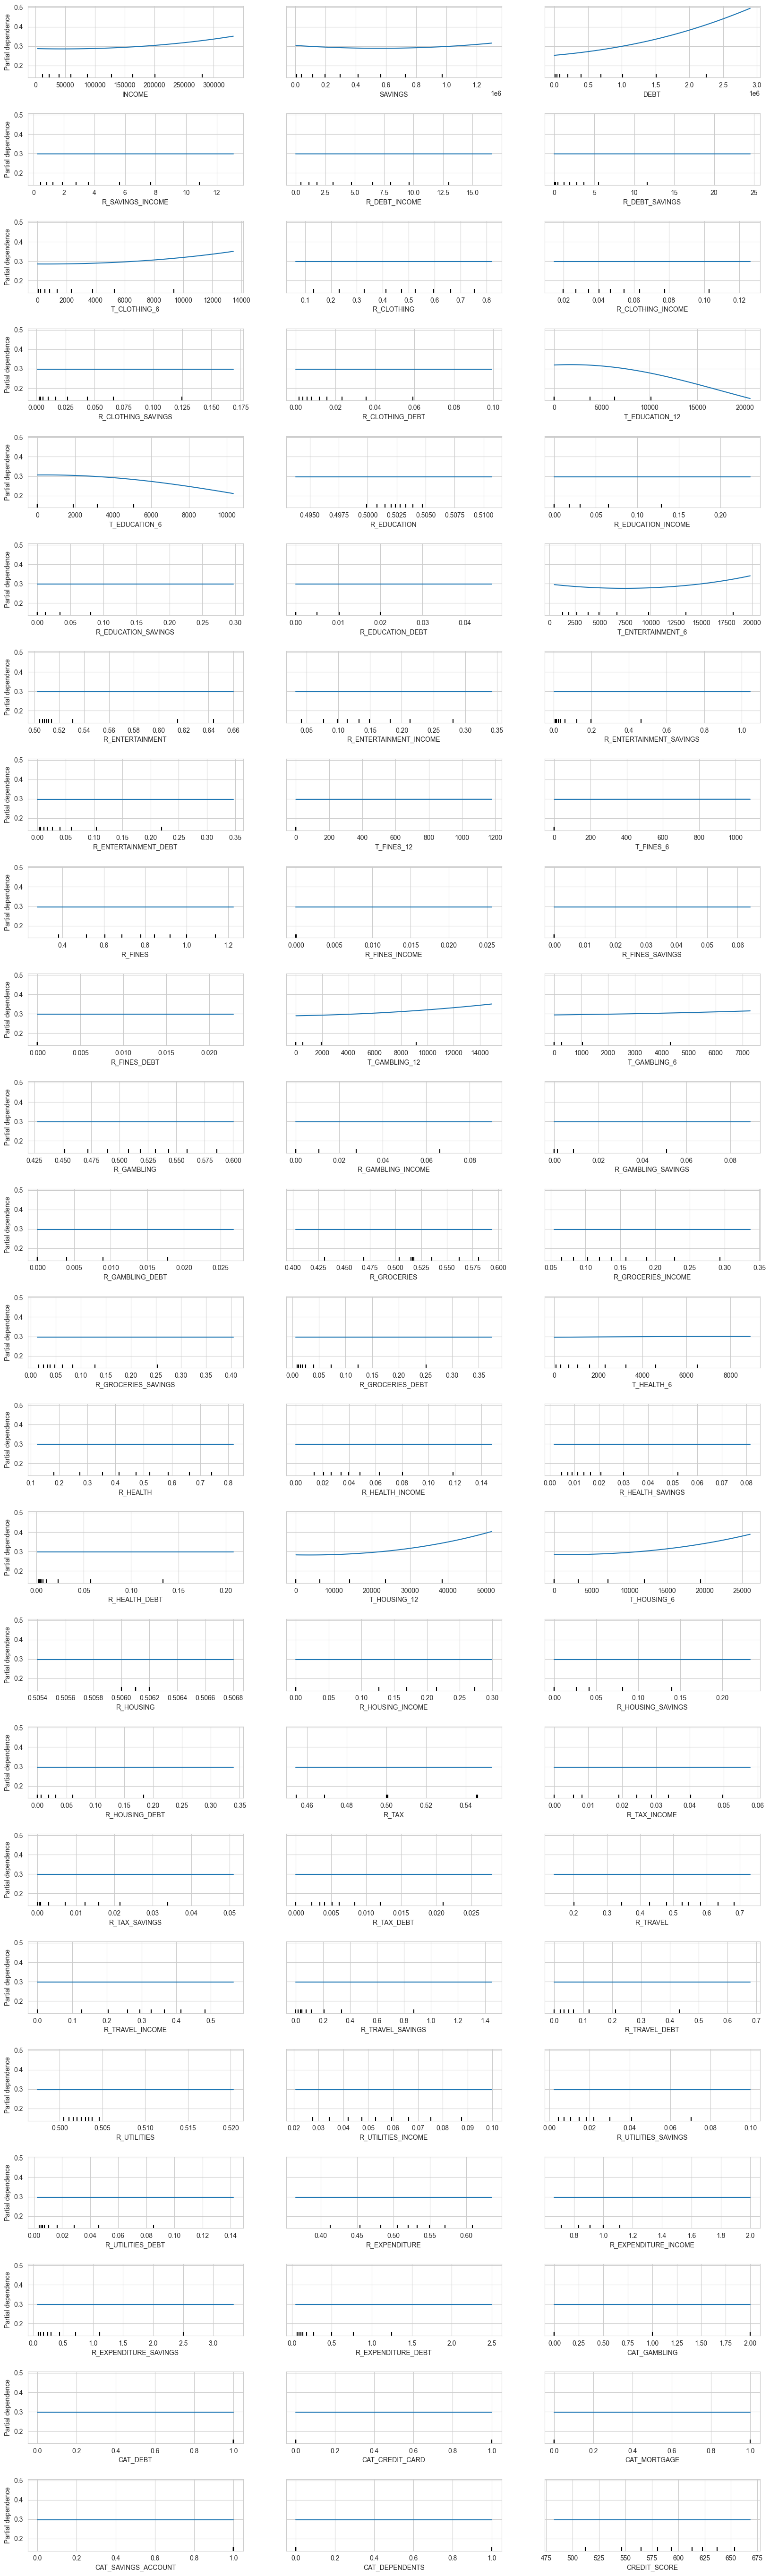

In [21]:
fig, ax = plt.subplots(figsize=(20, 70))
PartialDependenceDisplay.from_estimator(model_naive_bayes, X_train, features=list(range(72)), feature_names=col, ax=ax)
plt.subplots_adjust(hspace=0.5)

Conslusions:
- there are more linaer relationships between features and the model output than in the case of XGBoost.
- there are a lot of features (most of them) that have a marginal impact on the model output, only few has like any noticeable impact
- on the contrary to XGBoost, the most important feature is not CREDIT_SCORE, but CAT_SAVINGS_ACCOUNT.

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7428571428571429

Generation 2 - Current best internal CV score: 0.7428571428571429

Generation 3 - Current best internal CV score: 0.742857142857143

Generation 4 - Current best internal CV score: 0.7510204081632653

Generation 5 - Current best internal CV score: 0.7510204081632653

Best pipeline: ExtraTreesClassifier(GaussianNB(input_matrix), bootstrap=True, criterion=gini, max_features=0.7500000000000001, min_samples_leaf=12, min_samples_split=13, n_estimators=100)


X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have valid feature names, but GaussianNB was fitted with feature names
X does not have 

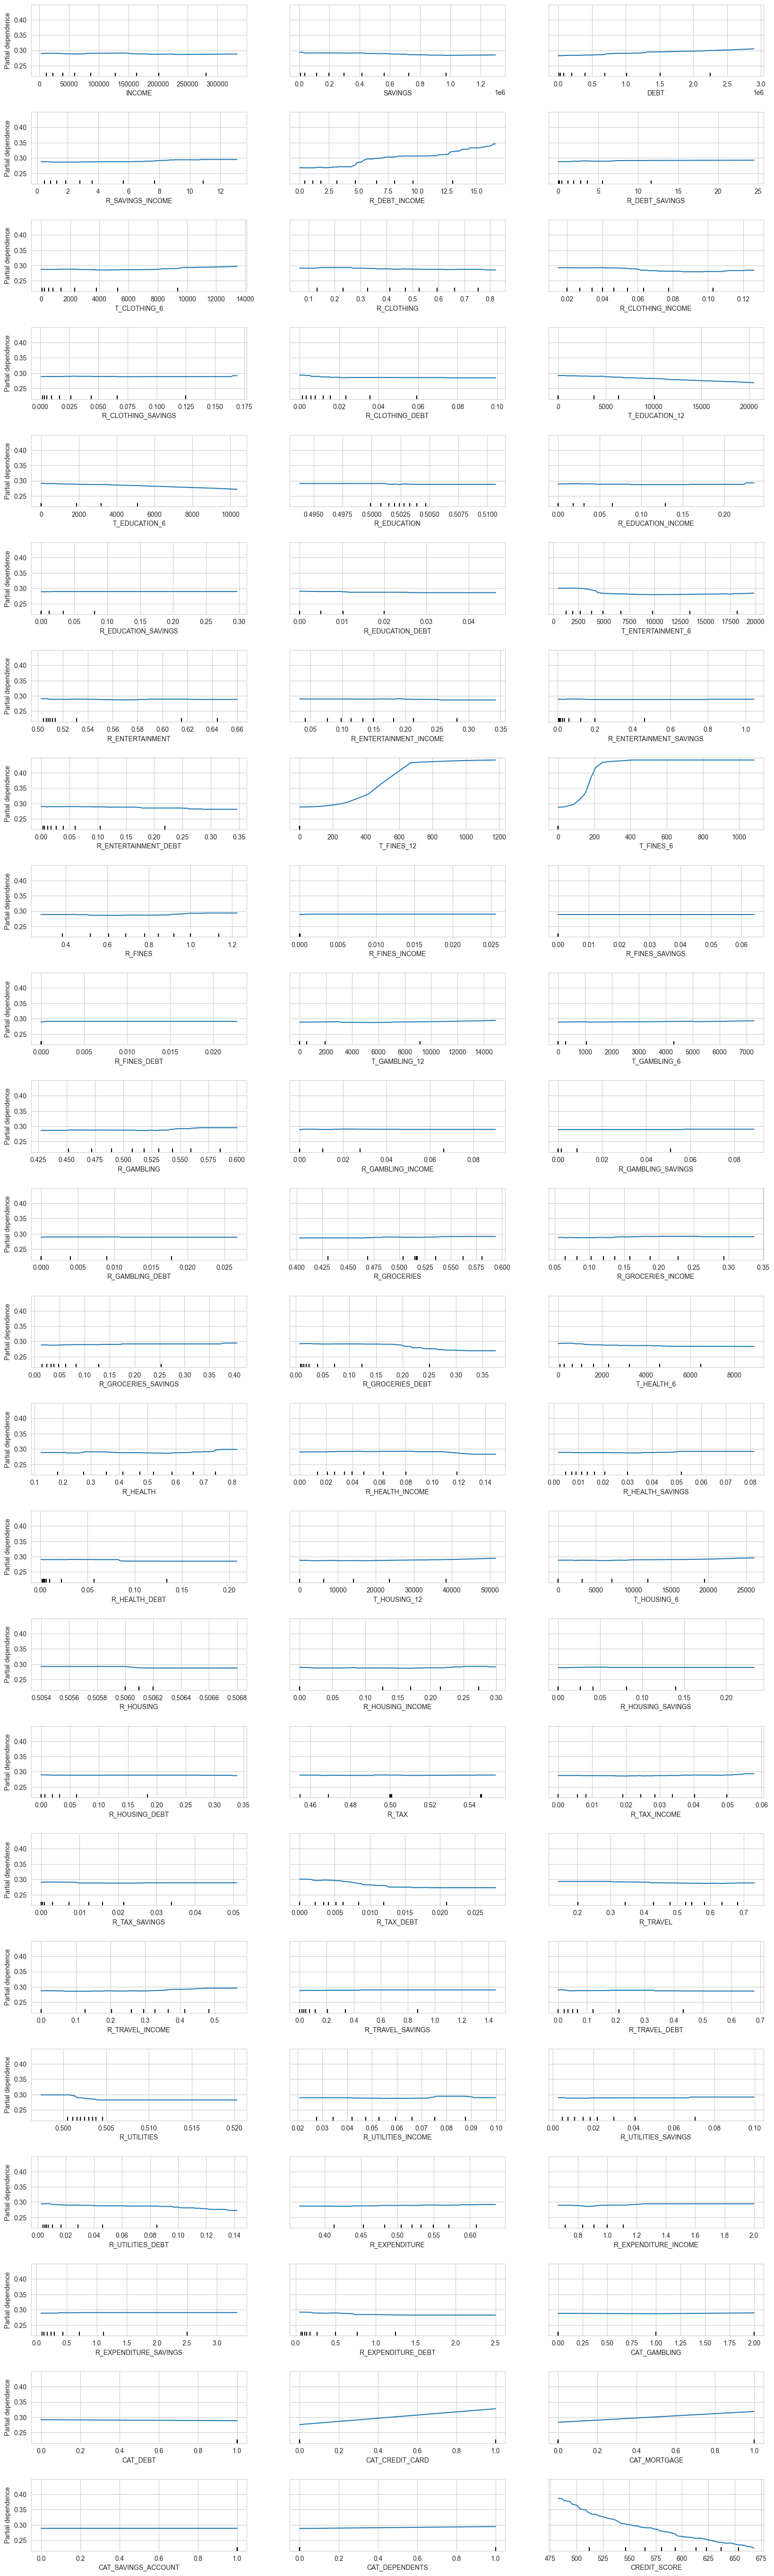

In [24]:
model_tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
model_tpot.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(20, 70))
PartialDependenceDisplay.from_estimator(model_tpot, X_train, features=list(range(72)), feature_names=col, ax=ax)
plt.subplots_adjust(hspace=0.5)

Conslusions:
- there aren't many linear relationships between features and the model output (and for sure less than in the case of Naive Bayes)
- there aren't a lot of features that have a marginal impact on the model output - most of them have some impact (bigger or smaller)
- (once again) the most important feature is CREDIT_SCORE, which is consistent with XGBoost (but not with Naive Bayes), some of other important features are: CAT_CREDIT_CARD and mostly all of R_(name of category)_DEBT
- interestingly, CAT_SAVINGS_ACCOUNT, which was the most important in Naive Bayes, here has marginal impact